# Anomaly Detection Prototype Experiments

In [1]:
import numpy as np
from sklearn import svm
from sklearn import covariance
from sklearn import ensemble
import matplotlib.pyplot as plt
%matplotlib inline

## Sort

分别使用标准库的的std::sort算法和自己编写的快速排序qsort算法，对随机生成的1000000个整数进行排序，并使用定时器记录排序算法所用的时间。运行100次并存储结果。

std::sort算法运行100次的时间，计算其均值和标准差

In [2]:
f = open('output_sort.txt', 'r')
sort_time = np.array([int(x) for x in f.readlines()])
np.mean(sort_time), np.std(sort_time)

(74.209999999999994, 12.004411689041659)

自定义qsort算法运行100的时间，计算其均值和方差

In [3]:
f = open('output_qsort.txt', 'r')
qsort_time = np.array([int(x) for x in f.readlines()])
np.mean(qsort_time), np.std(qsort_time)

(85.430000000000007, 4.6973503169340054)

之后我们使用std::sort的运行数据建立模型，用来判别一个数据点是否属于这一类。我们使用单类支持向量机（OneClassSVM）作为模型。

In [4]:
model = svm.OneClassSVM()
model.fit(sort_time.reshape(-1, 1))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

之后可以用训练出来的模型对于qsort产生的数据进行判别。注意到模型的输出为1表示和原来的一样，-1表示和原来的数据分布有明显不同。

In [5]:
predict = model.predict(qsort_time.reshape(-1, 1))
(predict == -1).sum()

78

我们可以看到对于100个qsort产生的数据中，有78个被正确的分类。

## Web Server

这里开始我试图使用/proc文件系统中的多维统计数据来进行异常状况的检测。我选择搭建了一个测试的web服务端和客户端，在服务端使用random产生延迟时间，然后再返回HTTP的response，用这样来模拟一种随机的网络延迟的状态。可以通过控制服务端的随机数分布的参数来达成不同的网络堵塞情况的模拟。

使用另一个程序用来监测web client的/proc运行统计信息。这里以1秒作为取样的间隔，取utime, stime, voluntary_ctxt_switches, nonvoluntary_ctxt_switches四个参数作为特征。

在两种不同的随机数分布的情况下进行测试。一是random为参数为1的指数分布，另一位参数为0.5的指数分布。同样使用其中的一类数据做OneClassSVM训练模型。

In [6]:
f = open('output_client.txt', 'r')
stats = [[int(x) for x in line.split()] for line in f.readlines()]
stats = np.array(stats)

In [7]:
np.mean(stats, axis=0)

array([   5.81278539,    1.02739726,   57.65753425,  173.77625571])

In [8]:
np.std(stats, axis=0)

array([  1.57509759,   0.99274909,  11.63707566,  42.57381645])

In [9]:
model_stats = svm.OneClassSVM()
model_stats.fit(stats)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [10]:
f = open('output_client_test.txt', 'r')
stats_test = [[int(x) for x in line.split()] for line in f.readlines()]
stats_test = np.array(stats_test)

In [11]:
np.mean(stats_test, axis=0)

array([  3.05504587,   0.6146789 ,  31.1559633 ,  97.13761468])

In [12]:
np.std(stats_test, axis=0)

array([  1.26225997,   0.75307634,   9.12318783,  30.04353657])

In [13]:
predict = model_stats.predict(stats_test)
(predict == -1).sum(), len(predict)

(107, 109)

这里注意看到在109个样例当中，训练出来的模型对于其中的107个都实现了正确的识别。

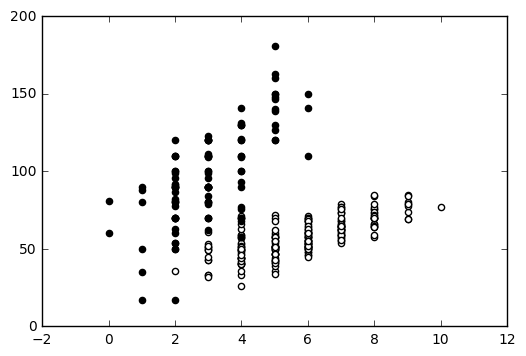

In [14]:
plt.scatter(stats[:,0], stats[:,2], c='white')
plt.scatter(stats_test[:,0], stats_test[:,3], c='black')
plt.show()

接下来使用unsupervised的方法试图进行异常样本的识别。从异常数据中取出一小部分和正常数据拼接成训练数据（考虑到异常应该是少数）。这里以下尝试了几种模型。

In [15]:
concat_data = np.concatenate((stats, stats_test[:10]), axis=0)
model_elliptic = covariance.EllipticEnvelope()
model_elliptic.fit(concat_data)
predict = model_elliptic.predict(stats_test)
(predict == -1).sum(), len(predict)

(26, 109)

EllipticEnvelop的识别准确率并不好

In [16]:
model_forest = ensemble.IsolationForest()
model_forest.fit(concat_data)
predict = model_forest.predict(stats_test)
(predict == -1).sum(), len(predict)

(62, 109)

IsolationForest的性能就好了很多，但是依然相比监督学习的模型有一定的差距。